# Self-supervised scene classification
Note that a lot of this code has been based on the practical session of the course.

In [1]:
import torch
from torchvision import datasets, transforms, models
import torchvision
from torch.optim import Adam, SGD

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
import time

import pandas as pd
import numpy as np

from PIL import Image

from torch import nn, optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import pickle
import itertools
import copy

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

torch.cuda.empty_cache() if torch.cuda.is_available() else None

Using device: cuda:0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
## settings
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 15
BATCH_SIZE = 15
NUM_EPOCHS = 20
LEARNING_RATE = 0.00005
OPTIMIZER = "Adam"

## 2 15-Scene Dataset
The dataset contains 15 categories of different scenes [1]. The categories are office,
kitchen, living room, bedroom, store, industrial, tall building, inside cite, street, highway,
coast, open country, mountain, forest, and suburb. The dataset has been divided into
two parts train and test. Each part has equally 15 different classes of scenes. The train
set is used during the training process in order to ”teach” the model how to classify images. The validation set is used to evaluate the model after each epoch, it is not seen
by the model during training. You will find the dataset in the BlackBoard platform, located at UA 2500WETANN: Artificial Neural Material > Practical Session > datasets >
self-supervised scene classification Project.

In [4]:
def get_scene_data_loader(batch_size):
    """
    Returns a train and validation data loader for the 15 scene dataset.

    :param batch_size: the batch size to use

    :return: the train and validation data loader
    """

    # # Transformations to be applied on the images
    # transform = transforms.Compose([
    #     transforms.Resize(INPUT_SHAPE[:2]),
    #     transforms.ToTensor()
    # ])

    # Since we're working with efficientnet, use the same transformations
    transform = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

    # print the transformations
    # print(transform)

    # Load the dataset
    data_folder = '15SceneData_small'
    # data_folder = '15SceneData'
    # data_folder = '/content/drive/My Drive/ann/15SceneData_small'

    train_folder = os.path.join(data_folder, 'train')
    val_folder = os.path.join(data_folder, 'validation')

    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # get the labels
    global LABELS
    LABELS = train_dataset.classes

    return train_loader, val_loader

In [5]:
train_loader, val_loader = get_scene_data_loader(BATCH_SIZE)

In [6]:
def visualize_3x3_images(images, labels, class_names=None):
    """
    Visualizes a 3x3 plot of images with their corresponding labels.

    :param images: the images to plot
    :param labels: the labels to plot
    """
    if class_names is None:
        class_names = LABELS

    fig, axes = plt.subplots(nrows=3, ncols=3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"{class_names[labels[i]]}")
        ax.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


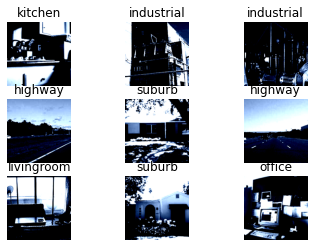

In [7]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
visualize_3x3_images(images, labels)

## 3 Classification schemes
In this section, the fully-supervised and self-supervised methods that should be implemented in this assignment are explained in more detail.

In [8]:
def get_n_fc_layers(model):
    """
    Returns the number of fully connected layers of a model.

    :param model: the model to get the number of fully connected layers from

    :return: the number of fully connected layers
    """
    n_fc_layers = 0
    for layer in model.children():
        if isinstance(layer, torch.nn.Linear):
            n_fc_layers += 1

    return n_fc_layers

In [9]:
class TrainLogger:
    def __init__(self, train_config, train_loader, val_loader, model, descr="", verbose=True):
        self.train_config = train_config

        self.train_loss_list_per_epoch = []
        self.train_loss_list_per_itr = []
        self.train_loss_list_all_itr = []
        self.train_accuracy_per_epoch = []

        self.val_loss_list = []
        self.val_accuracy_per_epoch = []

        self.time_s = time.time()

        time_str = time.strftime("%Y%m%d_%H%M%S")
        self.identifier = descr + "_" + time_str

        self.output_folder = os.path.join("outputs", self.identifier)
        os.makedirs(self.output_folder, exist_ok=True)

        self.time_e = None

        self.train_size = len(train_loader.dataset)
        self.val_size = len(val_loader.dataset)

        self.batch_size = train_loader.batch_size

        self.fc_layers = get_n_fc_layers(model)

        self.verbose = verbose

    def notify_itr_end(self, itr, train_loss):
        if itr % 10 == 0:
            self.train_loss_list_per_itr.append(train_loss.item())

    def notify_epoch_end(self, epoch, model, eval_loss, eval_acc, train_loss=None, train_acc=None):

        if train_loss is None:
            train_loss = np.mean(self.train_loss_list_per_itr)
        self.train_loss_list_per_epoch.append(train_loss)
        self.train_loss_list_all_itr.extend(self.train_loss_list_per_itr)
        self.train_loss_list_per_itr = []

        self.train_accuracy_per_epoch.append(train_acc)

        self.val_loss_list.append(eval_loss)
        self.val_accuracy_per_epoch.append(eval_acc)

        self.save_model(model, epoch)

        self.save_log_info()

        if self.verbose:
            print(f'Epoch {epoch} finished. '
                  f'Train loss: {self.train_loss_list_per_epoch[-1]}, '
                  f'Val loss: {eval_loss}, '
                  f'Val accuracy: {eval_acc}')

    def getting_worse(self, early_stop_count):
        if len(self.val_loss_list) < early_stop_count+1:
            return False

        epoch_before = self.val_loss_list[-early_stop_count-1]

        past_epochs = self.val_loss_list[-early_stop_count:]
        best_recent = np.min(past_epochs)

        return epoch_before < best_recent

    def get_train_duration(self):
        """Returns the duration of the training in minutes"""
        return (self.time_e - self.time_s) / 60

    def notify_train_end(self, model):
        self.time_e = time.time()
        self.save_log_info()
        self.save_model(model)
        self.plot_all()

    def plot_all(self):
        plt.plot(np.arange(len(self.train_loss_list_per_epoch)), self.train_loss_list_per_epoch, color='blue',
                 label='Train')
        plt.plot(np.arange(len(self.val_loss_list)), self.val_loss_list, color='red', label='Validation')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig(f'{self.output_folder}/train_val_loss.png')

        plt.cla()

        plt.plot(np.arange(len(self.val_accuracy_per_epoch)), self.val_accuracy_per_epoch, color='green',
                 label='Validation')
        plt.title('Validation Accuracy')
        plt.savefig(f'{self.output_folder}/validation_accuracy.png')

        plt.cla()

    def get_info_table(self):
        table = ""

        table_values = {
            "Input image size": self.train_config.input_size,
            "Learning rate": self.train_config.lr,
            "Optimizer": self.train_config.optimizer,
            "Batch size": self.batch_size,
            "Number of epochs": self.train_config.num_epochs,
            "Number of fully-connected layers": self.fc_layers
        }

        for key, value in table_values.items():
            table += f"{key}\t{value}\n"

        return table

    def save_model(self, model, epoch=None):
        if epoch is not None:
            filename = f'{self.output_folder}/model_epoch_{epoch}.pt'
        else:
            filename = f'{self.output_folder}/model.pt'

        torch.save(model.state_dict(), filename)

    def save_log_info(self):
        filename = f'{self.output_folder}/log.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(self, f)

        print(f"Saved log info to {filename}") if self.verbose else None

    def get_best_val_acc(self):
        return np.max(self.val_accuracy_per_epoch)

    def get_best_loss(self):
        return np.min(self.val_loss_list)

def load_log_info(path):
    with open(path, 'rb') as f:
        log = pickle.load(f)
    return log

In [10]:
class TrainConfig:
    def __init__(self, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS, criterion=None, optimizer=OPTIMIZER,
                 input_size=INPUT_SHAPE, batch_size=BATCH_SIZE):
        self.lr = lr
        self.num_epochs = num_epochs
        self.criterion = criterion if criterion else torch.nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.batch_size = batch_size # warning: be sure to use train_with_custom_batch_size

        if input_size != INPUT_SHAPE:
            print(
                f"Warning: different input size from config not supported (since this is the train config and not loader config)")

        self.input_size = input_size

    def get_optimizer(self, model):
        if self.optimizer == "Adam":
            return Adam(model.parameters(), lr=self.lr)
        elif self.optimizer == "SGD":
            return SGD(model.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("Optimizer not implemented")

In [11]:
def evaluation(model, validation_loader, criterion, pretext_task=None):
    val_loss = []

    real_label = None
    pred_label = None
    for inputs, labels in validation_loader:

        if pretext_task is not None:
            inputs, labels = pretext_task(inputs, labels)

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, preds = torch.max(outputs, 1)
        if real_label is None:
            real_label = labels.data
            pred_label = preds
        else:
            real_label = torch.cat((real_label, labels.data), dim=0)
            pred_label = torch.cat((pred_label, preds), dim=0)

        del inputs
        del labels

    real_label = real_label.detach().cpu().numpy()
    pred_label = pred_label.detach().cpu().numpy()

    eval_acc = accuracy_score(real_label, pred_label)
    # report = classification_report(real_label, pred_label)
    # eval_acc = float(report.split('accuracy')[1].split(' ')[27])

    return np.mean(val_loss), eval_acc

In [12]:
def train(model, train_loader, validation_loader, train_config, pretext_task=None, log_descr=None, verbose=True, early_stop_count=None):

    model.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = train_config.get_optimizer(model)

    log = TrainLogger(train_config=train_config,
                      train_loader=train_loader,
                      val_loader=validation_loader,
                      model=model,
                      descr=log_descr,
                      verbose=verbose)

    for epoch in range(train_config.num_epochs):
        for itr, (inputs, labels) \
                in tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        disable=not verbose):

            if pretext_task is not None:
                # change the inputs and labels to the pretext task
                inputs, labels = pretext_task(inputs, labels)

            model.train(True)

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # clearing old gradients from the last step
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # computing the derivative of the loss w.r.t. the parameters
            loss.backward()
            # optimizer takes a step in updating parameters based on the gradients of the parameters.
            optimizer.step()

            log.notify_itr_end(itr, train_loss=loss)

        # Evaluate model for each update iteration
        model.eval()
        with torch.no_grad():
            eval_loss, eval_acc = evaluation(model, validation_loader, criterion, pretext_task)

        # calculate the train accuracy
        train_loss, train_acc = evaluation(model, train_loader, criterion, pretext_task)

        log.notify_epoch_end(epoch, model=model, eval_loss=eval_loss, eval_acc=eval_acc, train_loss=train_loss,
                             train_acc=train_acc)

        if early_stop_count is not None and log.getting_worse(early_stop_count):
            print("Early stopping") if verbose else None
            break

    log.notify_train_end(model)

    return model, log

In [13]:
def train_on_custom_batch_size(model, train_config, pretext_task=None, log_descr=None, verbose=True, early_stop_count=None):

    batch_size = train_config.batch_size

    train_loader, val_loader = get_scene_data_loader(batch_size)

    model, log = train(model, train_loader, val_loader, train_config, pretext_task=pretext_task, log_descr=log_descr, verbose=verbose, early_stop_count=early_stop_count)

    return model, log

In [14]:
# load the model
def load_model(path, num_classes=NUM_CLASSES, evaluation_mode=True):
    model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

    classifier_in = model_efficient_b0.classifier[-1].in_features
    model_efficient_b0.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)

    model_efficient_b0.load_state_dict(torch.load(path))

    if evaluation_mode:
        model_efficient_b0.eval()

    return model_efficient_b0

In [15]:
def make_trainable(model, train_features: bool, train_classifier: bool):
    for params in model.features.parameters():
        params.requires_grad = train_features

    for params in model.classifier.parameters():
        params.requires_grad = train_classifier

In [16]:
def modify_classification_head(model, num_classes):
    classifier_in = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)
    return model

## Hyperparameter tuning

In [17]:
def tune_parameters(parameter_generator, gen_len,  model, train_config, pretext_task=None, early_stop_count=2, descr=""):

    results = []
    current_best = -np.inf
    best_parameter_set = None

    print(f"Starting hyperparameter search with {gen_len} parameter sets at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    for parameter_set in tqdm(parameter_generator, total=gen_len):
        try:
            lr, batch_size = parameter_set

            train_config.lr = lr
            train_config.batch_size = batch_size

            # copy the model, since we don't want to change the original
            model_old = copy.deepcopy(model)

            model, log = train_on_custom_batch_size(model, train_config, pretext_task=pretext_task,
                                                    log_descr=f"hypersearch_{descr}_{parameter_set}", verbose=False,
                                                    early_stop_count=early_stop_count)

            results.append((parameter_set, log))

            if log.get_best_val_acc() > current_best:
                current_best = log.get_best_val_acc()
                best_parameter_set = parameter_set

                print(f"New best parameter set: {best_parameter_set}, with accuracy {current_best}")

            model = model_old

        except Exception as e:
            print(f"Exception occurred while testing parameter set {parameter_set}: {e}")
            continue

    print(f"Best parameter set: {best_parameter_set}, with accuracy {current_best}")

    # save results to a pickle file
    time_str = time.strftime("%Y%m%d_%H%M%S")
    identifier = f"hypersearch_{descr}_{time_str}"
    filename = f"outputs/{identifier}.pickle"
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    return results, best_parameter_set

In [18]:
def grid_search_generator(lr_search_space, batch_size_search_space):

    combinations = list(itertools.product(lr_search_space, batch_size_search_space))

    for combination in combinations:
        yield combination


def grid_search(model, train_config, pretext_task=None,
        lr_search_space=None, batch_size_search_space=None, early_stop_count=2, descr=""):
    """
    Performs a grid search over the learning rate and batch size hyperparameters.
    *_search_space should be a list of values to try. if None, the values from train_config are used.

    Best to set num_epoch large enough, since early stopping is used.
    """
    if lr_search_space is None:
      lr_search_space = [train_config.lr]
    if batch_size_search_space is None:
      batch_size_search_space = [train_loader.batch_size]


    gen_len = len(lr_search_space) * len(batch_size_search_space)

    generator = grid_search_generator(lr_search_space, batch_size_search_space)

    results, best_parameter_set = tune_parameters(generator, gen_len, model, train_config, pretext_task=pretext_task, early_stop_count=early_stop_count, descr=descr)

In [19]:
def random_search_generator(lr_search_space, batch_size_search_space, n_combinations):
    for i in range(n_combinations):
        lr = np.random.choice(lr_search_space)
        batch_size = np.random.choice(batch_size_search_space)
        yield (lr, batch_size)

def random_search(model, train_config, pretext_task=None,
        lr_search_space=None, batch_size_search_space=None, n_combinations=10, early_stop_count=2, descr=""):
    # warning; search space are currently only lists, should be extended if you want to keep using this one

    if lr_search_space is None:
      lr_search_space = [train_config.lr]
    if batch_size_search_space is None:
      batch_size_search_space = [train_loader.batch_size]

    gen_len = n_combinations

    generator = random_search_generator(lr_search_space, batch_size_search_space, n_combinations)

    results, best_parameter_set = tune_parameters(generator, gen_len, model, train_config, pretext_task=pretext_task, early_stop_count=early_stop_count, descr=descr)

    return results, best_parameter_set

### Bayesian Optimization
https://kevinvecmanis.io/statistics/machine%20learning/python/smbo/2019/06/01/Bayesian-Optimization.html also explains visualization

In [20]:
torch.cuda.empty_cache()

In [21]:
global HYPEROPT_MODEL_PARAMS
HYPEROPT_MODEL_PARAMS = {
    "model": None,
    "pretext_task": None,
    'train_config': None,
    "best_loss": np.inf,
    "best_parameter_set": None,
    "all_results": [],
}

def objective(params):

    global HYPEROPT_MODEL_PARAMS
    model = HYPEROPT_MODEL_PARAMS["model"]
    pretext_task = HYPEROPT_MODEL_PARAMS["pretext_task"]
    train_config = HYPEROPT_MODEL_PARAMS["train_config"]
    best_loss = HYPEROPT_MODEL_PARAMS["best_loss"]

    lr = params['lr']
    batch_size = params['batch_size']

    train_config.lr = lr
    train_config.batch_size = batch_size

    parameter_set = (lr, batch_size)

    # copy the model, since we don't want to change the original
    model = copy.deepcopy(model)

    model, log = train_on_custom_batch_size(model, train_config, pretext_task=pretext_task,
                                            log_descr=f"hypersearch_bayesian_{parameter_set}", verbose=False,
                                            early_stop_count=2)

    loss = log.get_best_loss()
    if loss < best_loss:
        HYPEROPT_MODEL_PARAMS["best_loss"] = loss
        HYPEROPT_MODEL_PARAMS["best_parameter_set"] = parameter_set

        print(f"New best parameter set: {parameter_set}, with loss {loss}, accuracy {log.get_best_val_acc()}")

    HYPEROPT_MODEL_PARAMS["all_results"].append((parameter_set, log))

    return {'loss': loss, 'status': STATUS_OK}

In [22]:
def train_hyperopt(model, train_config, pretext_task=None, early_stop_count=2, descr=""):
    global HYPEROPT_MODEL_PARAMS
    HYPEROPT_MODEL_PARAMS["model"] = model
    HYPEROPT_MODEL_PARAMS["pretext_task"] = pretext_task
    HYPEROPT_MODEL_PARAMS["train_config"] = train_config
    HYPEROPT_MODEL_PARAMS["best_loss"] = np.inf
    HYPEROPT_MODEL_PARAMS["best_parameter_set"] = None
    HYPEROPT_MODEL_PARAMS["all_results"] = []

    space = {
      'lr': hp.loguniform('lr', np.log(0.00001), np.log(0.0001)),
        'batch_size': hp.choice('batch_size', [4])
      }

    start = time.time()
    trials = Trials()
    best = fmin(
      objective,
      space = space,
      algo = tpe.suggest,
      max_evals = 3,
      trials = trials
    )

    print(f"Best parameter set: {HYPEROPT_MODEL_PARAMS['best_parameter_set']}, with loss {HYPEROPT_MODEL_PARAMS['best_loss']}")

    print(f"Hyperopt took {time.time() - start} seconds")

    timestr = time.strftime("%Y%m%d_%H%M%S")
    filename = f"outputs/hyperopt_{descr}_{timestr}"
    pickle.dump(trials, open(f"{filename}_trials.pickle", "wb"))
    pickle.dump(HYPEROPT_MODEL_PARAMS["all_results"], open(f"{filename}_all.pickle", "wb"))
    # trials = pickle.load(open("trials.p", "rb")) # Pass this to Hyperopt during the next training run.

    return best, trials

## 3.1 Supervised learning scheme
In this section, you should fine-tune a convolutional neural network architecture, pretrained on the ImageNet [2] dataset, on the 15 scene dataset. In this assignment you will
use a pre-trained EfficientNet-B0 architecture. Following the exercise session on Transfer
Learning, you should make all layers in feature extraction and classifier parts of the model
trainable. The bellow address provides you with the scheme of the architecture of the
EfficientNet-B0.
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd

In [24]:

model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="supervised")

  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [47]:
log = load_log_info("outputs/supervised_20230815_131432/log.pickle")
log.__dict__

{'train_config': <__main__.TrainConfig at 0x15411d507f0>,
 'train_loss_list_per_epoch': [2.4382914781570433,
  1.6310137629508972,
  1.0452701270580291,
  0.6058094352483749,
  0.4736965179443359],
 'train_loss_list_per_itr': [],
 'train_loss_list_all_itr': [2.7217161655426025,
  2.628272533416748,
  2.4737870693206787,
  2.4755609035491943,
  2.5443220138549805,
  2.4686734676361084,
  2.406768321990967,
  2.2747182846069336,
  2.3324897289276123,
  2.0566062927246094,
  2.0880448818206787,
  2.1191513538360596,
  1.865885853767395,
  1.9637813568115234,
  1.5787184238433838,
  1.6249650716781616,
  1.4071656465530396,
  1.353121280670166,
  1.1650749444961548,
  1.1442288160324097,
  1.411100149154663,
  1.2891322374343872,
  0.930435299873352,
  1.4221676588058472,
  1.0019599199295044,
  0.9947680234909058,
  0.76671302318573,
  0.6601670980453491,
  0.9153639674186707,
  1.0608938932418823,
  0.8233617544174194,
  0.899783730506897,
  0.6796985268592834,
  0.542612612247467,
  1.0

### Hyperparameter tuning

In [23]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

# grid search
lr_search_space = [0.00001, 0.00005, 0.0001, 0.001]

results, best_parameter_set = grid_search(model_efficient_b0, train_config,
                                          lr_search_space=lr_search_space)

Starting hyperparameter search with 4 parameter sets at 2023-08-21 22:50:59


  0%|          | 0/4 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [20]:
results

[((1e-05, 15), <__main__.TrainLogger at 0x2396ac759d0>),
 ((5e-05, 15), <__main__.TrainLogger at 0x2396ac75c10>),
 ((0.0001, 15), <__main__.TrainLogger at 0x2396ac75a30>),
 ((0.001, 15), <__main__.TrainLogger at 0x2395f506850>)]

In [21]:
for param_set, log in results:
    print(f"Parameter set: {param_set}, with accuracy {log.get_best_val_acc()}")


Parameter set: (1e-05, 15), with accuracy 0.3280757097791798
Parameter set: (5e-05, 15), with accuracy 0.6876971608832808
Parameter set: (0.0001, 15), with accuracy 0.7539432176656151
Parameter set: (0.001, 15), with accuracy 0.7097791798107256


New best parameter set: (2.2528591748141758e-05, 4), with loss 1.9147375524044037, accuracy 0.5331230283911672
New best parameter set: (6.112074195645728e-05, 4), with loss 1.0518038688227533, accuracy 0.6876971608832808
100%|██████████| 3/3 [08:26<00:00, 168.88s/trial, best loss: 1.0518038688227533]
Best parameter set: (6.112074195645728e-05, 4), with loss 1.0518038688227533
Hyperopt took 506.65531730651855 seconds


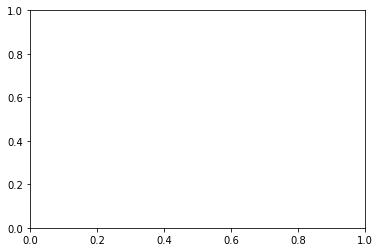

In [23]:
# hyperopt
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
make_trainable(model_efficient_b0, train_features=True, train_classifier=True)
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

best, trials = train_hyperopt(model_efficient_b0, train_config, early_stop_count=2, descr="supervised")

In [45]:
trials

In [35]:
del HYPEROPT_MODEL_PARAMS, images

## 3.2 Self-supervised learning scheme

### 3.2.1 Pretext Task 1: Rotation Classification

In [61]:
class RotationPretext:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: rotated images and labels corresponding to the rotation angle
        """
        for i in range(len(inputs)):
            angle_index = np.random.randint(len(self.angles))
            angle = self.angles[angle_index]
            inputs[i] = transforms.functional.rotate(inputs[i], angle)
            labels[i] = angle_index
        return inputs, labels

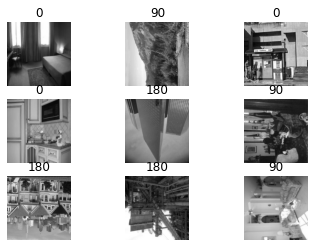

In [62]:
# test the rotation pretext task
images, labels = next(iter(train_loader))

angles = [0, 90, 180, 270]
rotation_pretext = RotationPretext([0, 90, 180, 270])
images, labels = rotation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=angles)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 0 finished. Train loss: 1.2767265081405639, Val loss: 1.1020681019404426, Val accuracy: 0.6301507537688442


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 1 finished. Train loss: 0.9710584878921509, Val loss: 0.7214778622790198, Val accuracy: 0.7360134003350084


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 2 finished. Train loss: 0.6806121051311493, Val loss: 0.5486773288429682, Val accuracy: 0.7819095477386935


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 3 finished. Train loss: 0.515928253531456, Val loss: 0.4078117567839934, Val accuracy: 0.8609715242881072


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 4 finished. Train loss: 0.4220299690961838, Val loss: 0.3040443463016994, Val accuracy: 0.8921273031825796


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 5 finished. Train loss: 0.4014567732810974, Val loss: 0.24943770015209762, Val accuracy: 0.916247906197655


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 6 finished. Train loss: 0.2922484800219536, Val loss: 0.23945645967395462, Val accuracy: 0.9082077051926298


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 7 finished. Train loss: 0.2114729590713978, Val loss: 0.20405403462861052, Val accuracy: 0.9262981574539364


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 8 finished. Train loss: 0.2766255922615528, Val loss: 0.18444941215329433, Val accuracy: 0.9336683417085427


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 9 finished. Train loss: 0.1805283334106207, Val loss: 0.17941295226624038, Val accuracy: 0.9326633165829146


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 10 finished. Train loss: 0.2030869111418724, Val loss: 0.1796729682509474, Val accuracy: 0.9333333333333333


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 11 finished. Train loss: 0.19668276980519295, Val loss: 0.1797375951977868, Val accuracy: 0.9309882747068676


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 12 finished. Train loss: 0.13910977691411971, Val loss: 0.17175760868019493, Val accuracy: 0.9390284757118929


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 13 finished. Train loss: 0.13546560583636164, Val loss: 0.17056764042632064, Val accuracy: 0.9373534338358459


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 14 finished. Train loss: 0.1411359048448503, Val loss: 0.16238697395828464, Val accuracy: 0.9390284757118929
Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 0 finished. Train loss: 2.6581330060958863, Val loss: 2.5480466260382877, Val accuracy: 0.21105527638190955


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 1 finished. Train loss: 2.5082597732543945, Val loss: 2.378852463247788, Val accuracy: 0.35443886097152427


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 2 finished. Train loss: 2.389182949066162, Val loss: 2.2434235805243103, Val accuracy: 0.44187604690117255


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 3 finished. Train loss: 2.228971171379089, Val loss: 2.107219751755796, Val accuracy: 0.521608040201005


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 4 finished. Train loss: 2.1947611570358276, Val loss: 1.9897879380077572, Val accuracy: 0.5735343383584589


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 5 finished. Train loss: 2.0003522634506226, Val loss: 1.906836446805216, Val accuracy: 0.6040201005025125


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 6 finished. Train loss: 2.014079678058624, Val loss: 1.8094266880696743, Val accuracy: 0.6187604690117253


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 7 finished. Train loss: 1.938401222229004, Val loss: 1.7313602761407594, Val accuracy: 0.6391959798994975


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 8 finished. Train loss: 1.760658848285675, Val loss: 1.6573268893975108, Val accuracy: 0.6559463986599665


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 9 finished. Train loss: 1.6840951204299928, Val loss: 1.614261927916177, Val accuracy: 0.6636515912897822


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 10 finished. Train loss: 1.8233296990394592, Val loss: 1.5263743813912474, Val accuracy: 0.6767169179229481


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 11 finished. Train loss: 1.6617978096008301, Val loss: 1.4664054923321135, Val accuracy: 0.6958123953098827


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 12 finished. Train loss: 1.5537155628204347, Val loss: 1.430328898693449, Val accuracy: 0.7015075376884422


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 13 finished. Train loss: 1.4632452964782714, Val loss: 1.37281569883452, Val accuracy: 0.7051926298157454


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 14 finished. Train loss: 1.5105182528495789, Val loss: 1.341849385194443, Val accuracy: 0.7139028475711893
Saved log info to outputs\pretext_rotation_20230612_191753/log.txt


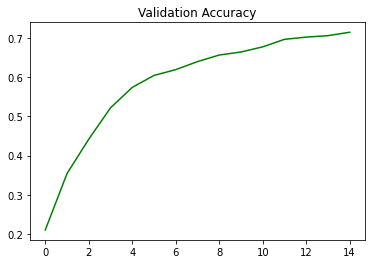

In [63]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_rotation")

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_rotation")

### 3.2.2 Pretext Task 2: Perturbation Classification

In [64]:
class PerturbationPretext:
    def __init__(self, perbutation_colors=[0, 255]):
        self.perbutation_colors = perbutation_colors

    def __call__(self, inputs, labels):
        """
        :param inputs: batch of images
        :param labels: batch of labels
        :return: perturbed images and labels corresponding the perturbation color
        """
        for i in range(len(inputs)):
            perturbation_index = np.random.randint(len(self.perbutation_colors))
            perturbation_color = self.perbutation_colors[perturbation_index]
            inputs[i] = self._apply_perturbation(inputs[i], perturbation_color)
            labels[i] = perturbation_index
        return inputs, labels

    def _apply_perturbation(self, input, color):
        """
        To do the perturbation you need to define a random square region W with a shape 10 × 10 on an image. Then, the pixels within the window are set to given color
        """
        region_size = 10
        x = np.random.randint(0, input.shape[1] - region_size)
        y = np.random.randint(0, input.shape[2] - region_size)
        input[:, x:x + region_size, y:y + region_size] = color
        return input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


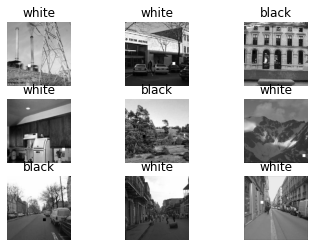

In [65]:
# test the perturbation pretext task
images, labels = next(iter(train_loader))

perturbation_pretext = PerturbationPretext()
images, labels = perturbation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=["black", "white"])

In [66]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

pretext_task = PerturbationPretext()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_perturbation")

100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 0 finished. Train loss: 0.35623098388314245, Val loss: 0.031000657259818896, Val accuracy: 1.0


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 1 finished. Train loss: 0.03266912191174924, Val loss: 0.005134624172816399, Val accuracy: 0.9996649916247906


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 2 finished. Train loss: 0.018416068237274884, Val loss: 0.0019554156218023607, Val accuracy: 1.0


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 3 finished. Train loss: 0.006387770245783031, Val loss: 0.000830611428591053, Val accuracy: 1.0


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 4 finished. Train loss: 0.003682026104070246, Val loss: 0.0004685725072713513, Val accuracy: 1.0


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 5 finished. Train loss: 0.0032891454466152936, Val loss: 0.0002999342880744122, Val accuracy: 1.0


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Saved log info to outputs\pretext_only_perturbation_20230612_193316/log.txt
Epoch 6 finished. Train loss: 0.003245800724835135, Val loss: 0.00027229502357205553, Val accuracy: 1.0


 34%|███▍      | 34/100 [00:21<00:41,  1.60it/s]


KeyboardInterrupt: 

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 0 finished. Train loss: 2.7325305461883547, Val loss: 2.6276729681983064, Val accuracy: 0.13835845896147403


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 1 finished. Train loss: 2.5749547719955443, Val loss: 2.5265056296209596, Val accuracy: 0.27571189279731995


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 2 finished. Train loss: 2.4905959606170653, Val loss: 2.4385680241800434, Val accuracy: 0.3849246231155779


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 3 finished. Train loss: 2.3960495710372927, Val loss: 2.3459761070845713, Val accuracy: 0.45494137353433833


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 4 finished. Train loss: 2.281072902679443, Val loss: 2.2591456396495877, Val accuracy: 0.5139028475711893


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 5 finished. Train loss: 2.192849326133728, Val loss: 2.1781382986049556, Val accuracy: 0.5474036850921273


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 6 finished. Train loss: 2.12586704492569, Val loss: 2.11123553232931, Val accuracy: 0.5792294807370184


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 7 finished. Train loss: 2.1030843615531922, Val loss: 2.0553200700175225, Val accuracy: 0.6040201005025125


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 8 finished. Train loss: 2.022720766067505, Val loss: 1.9619139283146692, Val accuracy: 0.6438860971524288


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 9 finished. Train loss: 1.9296969771385193, Val loss: 1.9197235994003525, Val accuracy: 0.6455611390284757


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 10 finished. Train loss: 1.8853028535842895, Val loss: 1.855462760781523, Val accuracy: 0.6596314907872697


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 11 finished. Train loss: 1.79427490234375, Val loss: 1.8138326436430965, Val accuracy: 0.671356783919598


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 12 finished. Train loss: 1.7792096853256225, Val loss: 1.7533776226954245, Val accuracy: 0.6894472361809045


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 13 finished. Train loss: 1.7163466572761537, Val loss: 1.7250414673407473, Val accuracy: 0.6807370184254606


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 14 finished. Train loss: 1.7008320093154907, Val loss: 1.6658432831117256, Val accuracy: 0.6984924623115578
Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt


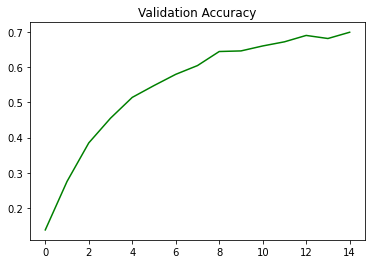

In [67]:
# Load the model from the pretext task (epoch 2)
model_efficient_b0 = load_model("outputs/pretext_only_perturbation_20230612_193316/model_epoch_2.pt", 2)

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_perturbation")

# Model explanation and interpretation
In this section, you are requested to explain and interpret the models trained following the
fully-supervised and self-supervised procedures.

In [19]:
MODEL_SAVES = {
    "supervised": "outputs/supervised_20230612_181931/model.pt",
    "pretext_rotation": "outputs/pretext_rotation_20230612_191753/model.pt",
    "pretext_perturbation": "outputs/pretext_perturbation_20230612_194842/model.pt"
}


## Explanation

In [77]:
from torchcam.methods import ScoreCAM

def get_explanation(model, image, layer, label=None):
    # image = image.unsqueeze(0)

    cam = ScoreCAM(model)#, target_layer=layer)

    out = model(image)

    label_idx = out.argmax() # todo: out.squeezee(0) or not?

    if label is None:
        label = label_idx

    if not label_idx == label:
        print("Warning: model prediction is not equal to the actual label")

    explanation = cam(out.squeeze(0).argmax().item(), out) # int, out as parameter?

    return explanation


def get_last_conv_layer(sequence):
    # warning: this function doesn't work for nested sequences
    for layer in reversed(sequence):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    raise Exception("No convolutional layer found")


def explain_predictions(model, images):
    """
    :param model: model to explain (efficientnet modification)
    :param images: images to explain (batch, already as tensor) and labels
    """
    explanations_lower_layer_b1 = []
    explanations_lower_layer_b2 = []
    explanations_higher_layer = []

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.classifier[1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    explenations = []

    for image, label in zip(images[0], images[1]):
        # get the explanation for the higher layer
        explanation_higher_layer = get_explanation(model, image, last_conv_layer, label)
        explanations_higher_layer.append(explanation_higher_layer)

        # get the explanation for the lower layer
        explanation_lower_layer_b1 = get_explanation(model, image, first_block, label)
        explanations_lower_layer_b1.append(explanation_lower_layer_b1)

        explanation_lower_layer_b2 = get_explanation(model, image, second_block, label)
        explanations_lower_layer_b2.append(explanation_lower_layer_b2)

        # explanations = [(explanations_lower_layer_b1, "Conv b1"), (explanations_lower_layer_b2, "Conv b2"),
        #                 (explanations_higher_layer, "Last conv")]

        expl = {"img": image,
                "label": label,
                "convb1": explanations_lower_layer_b1,
                "convb2": explanations_lower_layer_b2,
                "lastconv": explanations_higher_layer}

        explenations.append(expl)

    return explenations


In [74]:
def get_correctly_predicted_images(model, loader, num_images=8):
    """
    :param model: model to explain (efficientnet modification)
    :param loader: loader to get images from
    :param num_images: number of images to get
    :return: list of images and labels
    """
    images = []
    labels = []
    for image_batch, label_batch in loader:
        for image, label in zip(image_batch, label_batch):
            image = image.unsqueeze(0)
            prediction = model(image)
            prediction = torch.argmax(prediction, dim=1)
            if prediction == label:
                images.append(image)
                labels.append(label)
            if len(images) == num_images:
                break
        if len(images) == num_images:
            break
    return images, labels

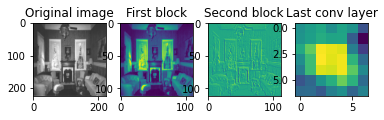

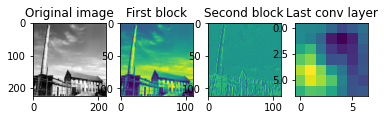

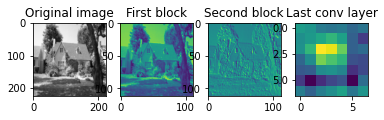

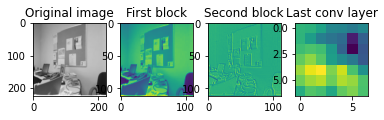

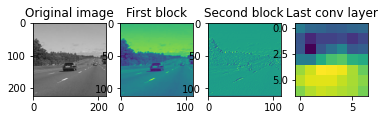

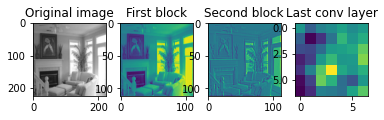

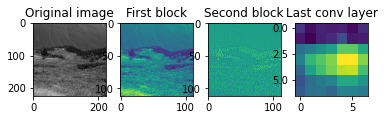

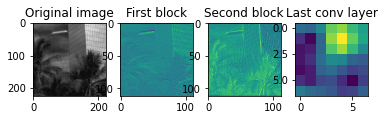

In [102]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "supervised"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

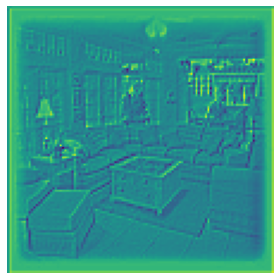

In [93]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [78]:
model = load_model(MODEL_SAVES["supervised"])
images_to_explain = get_correctly_predicted_images(model, val_loader, num_images=1)
explain_predictions(model, images_to_explain)

[{'img': tensor([[[[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0471, 0.0431],
            ...,
            [0.0471, 0.0510, 0.0510,  ..., 0.0784, 0.0863, 0.0784],
            [0.0471, 0.0510, 0.0510,  ..., 0.0902, 0.1020, 0.1255],
            [0.0471, 0.0510, 0.0510,  ..., 0.0863, 0.0902, 0.1490]],
  
           [[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0471, 0.0431],
            ...,
            [0.0471, 0.0510, 0.0510,  ..., 0.0784, 0.0863, 0.0784],
            [0.0471, 0.0510, 0.0510,  ..., 0.0902, 0.1020, 0.1255],
            [0.0471, 0.0510, 0.0510,  ..., 0.0863, 0.0902, 0.1490]],
  
           [[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],

In [ ]:
def plot_explanations(explanations):
    for expl_dict in explanations:
        img = expl_dict["img"]
        label = expl_dict["label"]
        convb1 = expl_dict["convb1"]
        convb2 = expl_dict["convb2"]
        lastconv = expl_dict["lastconv"]

        # plot the image
        plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        plt.title(f"Label: {label}")

        # plot the explanations
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(convb1[0].squeeze(0).numpy())
        axs[0].set_title("Conv b1")
        axs[1].imshow(convb2[0].squeeze(0).numpy())
        axs[1].set_title("Conv b2")
        axs[2].imshow(lastconv[0].squeeze(0).numpy())
        axs[2].set_title("Last conv")
        plt.show()

        plt.clf()

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

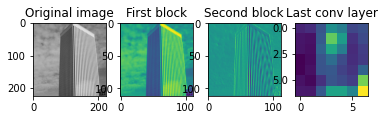

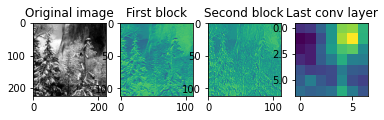

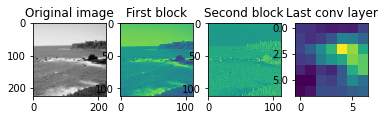

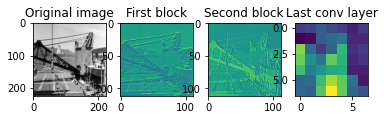

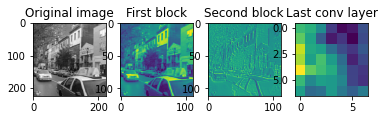

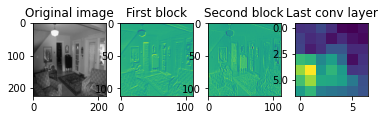

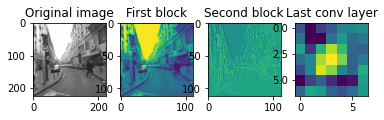

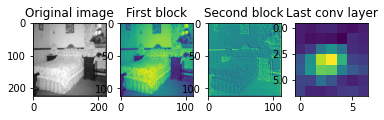

In [103]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "pretext_rotation"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

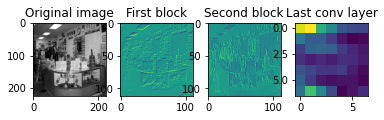

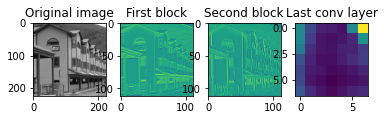

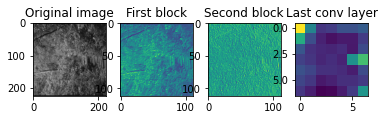

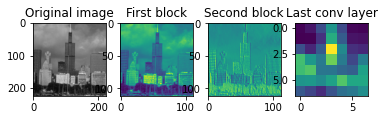

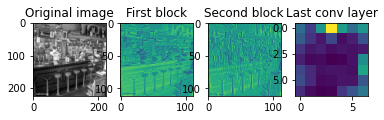

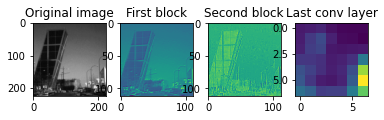

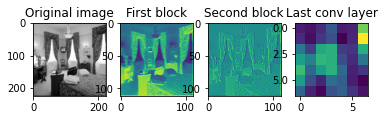

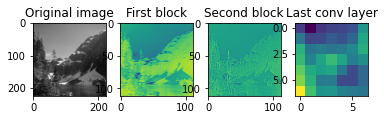

In [104]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "pretext_perturbation"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [30]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
batch = next(iter(val_loader))
explain_predictions(model, batch)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of torch.Size([224, 224]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.


## Interpretation
For the interpretation part, you should utilize the model inversion method proposed
in [3]. This model inversion technique is part of the last exercise session.

In [113]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration

# select 5 classes randomly
target_classes = np.random.choice(LABELS, 5, replace=False)
target_classes = ["street", "forest", "opencountry", "mountain", "tallbuilding"]

def get_interpretation(model, output_dir):
    for target_class in target_classes:
        print(f"Generating interpretation for class {target_class}")
        target_class_idx = LABELS.index(target_class)

        csig = RegularizedClassSpecificImageGeneration(model, target_class_idx, output_dir=output_dir, grayscale=False)

        # model.train(True)

        with torch.enable_grad(): # it's not calculating the grads for all models except for efficientnet, no idea whats the difference, since only the image has grads and the model is frozen. Probably pytorch version issues.
            csig.generate(iterations=1000)

In [114]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model, output_dir="outputs/interpretations/supervised")

Generating interpretation for class street


C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:95: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 111 Loss -0.05
Iteration: 222 Loss -0.28
Iteration: 333 Loss 0.28
Iteration: 444 Loss -0.26
Iteration: 555 Loss -0.41
Iteration: 666 Loss -0.14
Iteration: 777 Loss -0.06
Iteration: 888 Loss -0.39


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'outputs/interpretations/supervised/class_12' -> 'outputs/interpretations/supervised/class_12_blurfreq_4_blurrad_1_wd0.0001'

In [25]:
model = load_model(MODEL_SAVES["pretext_rotation"])
get_interpretation(model, output_dir="outputs/interpretations/pretext_rotation")

Generating interpretation for class street


C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:94: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 111 Loss 0.75
Iteration: 222 Loss 0.44
Iteration: 333 Loss 0.77
Iteration: 444 Loss 0.48
Iteration: 555 Loss 0.47
Iteration: 666 Loss 0.70
Iteration: 777 Loss 0.44
Iteration: 888 Loss 0.22
Generating interpretation for class forest
Iteration: 111 Loss 0.97
Iteration: 222 Loss 0.75
Iteration: 333 Loss 1.10
Iteration: 444 Loss 0.45
Iteration: 555 Loss 0.46
Iteration: 666 Loss 1.21


KeyboardInterrupt: 

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
get_interpretation(model, output_dir="outputs/interpretations/pretext_perturbation")

In [36]:
model_efficient_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
get_interpretation(model_efficient_b0, output_dir="outputs/interpretations/efficient_b0")

Generating interpretation for class street
Iteration: 111 Loss 0.26
Iteration: 222 Loss -0.18
Iteration: 333 Loss 0.24
Iteration: 444 Loss -0.66
Iteration: 555 Loss -0.68
Iteration: 666 Loss -0.27
Iteration: 777 Loss -0.20
Iteration: 888 Loss -0.78
Generating interpretation for class forest
Iteration: 111 Loss -0.13
Iteration: 222 Loss -0.42
Iteration: 333 Loss 0.01
Iteration: 444 Loss -0.88
Iteration: 555 Loss -0.61
Iteration: 666 Loss -0.97
Iteration: 777 Loss -0.63
Iteration: 888 Loss -0.79
Generating interpretation for class opencountry
Iteration: 111 Loss -0.30


KeyboardInterrupt: 

# Evaluation

In [17]:
def evaluation_report(model, loader):
    """
    :param model: the model to be evaluated
    :param loader: the loader to be used for evaluation
    :return: the classification report and the confusion matrix
    """
    y_true = []
    y_pred = []

    for images, labels in loader:
        y_true.extend(labels.numpy())
        predictions = model(images)
        predictions = torch.argmax(predictions, dim=1)
        y_pred.extend(predictions.numpy())


    return classification_report(y_true, y_pred, target_names=LABELS), confusion_matrix(y_true, y_pred)

In [18]:
for model_name in MODEL_SAVES:
    model = load_model(MODEL_SAVES[model_name])
    report, confusion = evaluation_report(model, val_loader)
    print(f"Model: {model_name}")
    print(report)
    print(confusion)

    # print latex table of the confusion matrix
    table = pd.DataFrame(confusion, index=LABELS, columns=LABELS)
    print(table.to_latex())

    print("\n\n")



Model: supervised
              precision    recall  f1-score   support

     bedroom       0.86      0.88      0.87       116
       coast       0.90      0.97      0.93       260
      forest       0.94      0.96      0.95       228
     highway       0.93      0.96      0.95       160
  industrial       0.93      0.90      0.91       211
  insidecity       0.91      0.93      0.92       208
     kitchen       0.93      0.95      0.94       110
  livingroom       0.91      0.90      0.91       189
    mountain       0.96      0.95      0.95       274
      office       0.96      0.97      0.97       115
 opencountry       0.93      0.87      0.90       310
       store       0.98      0.96      0.97       215
      street       0.95      0.93      0.94       192
      suburb       0.98      1.00      0.99       141
tallbuilding       0.97      0.95      0.96       256

    accuracy                           0.94      2985
   macro avg       0.94      0.94      0.94      2985
weighted

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_rotation
              precision    recall  f1-score   support

     bedroom       0.64      0.75      0.69       116
       coast       0.76      0.74      0.75       260
      forest       0.80      0.74      0.77       228
     highway       0.70      0.80      0.75       160
  industrial       0.83      0.40      0.54       211
  insidecity       0.78      0.63      0.70       208
     kitchen       0.43      0.65      0.52       110
  livingroom       0.69      0.50      0.58       189
    mountain       0.77      0.74      0.76       274
      office       0.62      0.73      0.67       115
 opencountry       0.62      0.71      0.66       310
       store       0.71      0.74      0.73       215
      street       0.73      0.85      0.78       192
      suburb       0.77      0.96      0.85       141
tallbuilding       0.82      0.82      0.82       256

    accuracy                           0.71      2985
   macro avg       0.71      0.72      0.70      2985
we

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_perturbation
              precision    recall  f1-score   support

     bedroom       0.59      0.79      0.68       116
       coast       0.67      0.58      0.62       260
      forest       0.73      0.70      0.71       228
     highway       0.66      0.79      0.72       160
  industrial       0.77      0.55      0.64       211
  insidecity       0.71      0.62      0.66       208
     kitchen       0.62      0.72      0.67       110
  livingroom       0.78      0.56      0.65       189
    mountain       0.68      0.74      0.71       274
      office       0.70      0.90      0.79       115
 opencountry       0.56      0.55      0.56       310
       store       0.85      0.80      0.82       215
      street       0.69      0.76      0.72       192
      suburb       0.77      0.92      0.84       141
tallbuilding       0.76      0.79      0.78       256

    accuracy                           0.70      2985
   macro avg       0.70      0.72      0.70      298

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


In [ ]:



def explain_predictions(model, val_batch):
    """
    Takesimages from the validation set and generates a Score-CAM explanation for each of them.
    :param model: the model to be explained
    :param val_batch: the validation set images and labels to explain
    """

    explanations = []

    images = val_batch[0]
    labels = val_batch[1]

    for image, label in zip(images, labels):
        # get the explanation for the final layr
        target_layer = model._modules.get('classifier')  # tODO: dit of model.classifier[-1]
        cam_extractor = ScoreCAM(model=model, target_layer=target_layer)

        # get the explanation for the image
        explanation = cam_extractor(image, target_category=label)
        explanations.append(explanation)

        # create plots, where each row contais the original image, the heatmap and the heatmap overlayed on the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        ax[1].imshow(explanation.squeeze().permute(1, 2, 0))
        ax[1].set_title("Heatmap")

        ax[2].imshow(image.permute(1, 2, 0))
        ax[2].imshow(explanation.squeeze().permute(1, 2, 0), alpha=0.5)
        ax[2].set_title("Heatmap overlayed on the original image")


images_to_explain = next(iter(val_loader))[0][:3]